### If you have questions or issues you can send emails to Iman or John.

In [1]:
# +
import numpy as np
from monai.utils.enums import MetricReduction

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    NormalizeIntensity,
    NormalizeIntensityd,
    Resized,
    EnsureTyped
)
from optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch

import os
import glob
import json
def save_pet(pet, filename):
    with open(filename, 'w') as f:
        f.write(json.dumps(pet))

def load_pet(filename):
    with open(filename) as f:
        pet = json.loads(f.read())
    return pet



In [2]:
roi_x = 64
roi_y = 64
roi_z = 64

roi = (roi_x, roi_y, roi_z)
import torch
device = torch.device("cuda:0")
from monai.data import CacheDataset, DataLoader, Dataset, load_decathlon_datalist

num_samples = 1
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=2000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(2.5, 2.5, 1), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(roi_x, roi_y, roi_z),
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=2000, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(2.5, 2.5, 1),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], track_meta=True),
    ]
)

# -



# +


In [3]:

data_list_file_path = "/src/workspace/BTCV/data_list_siim_internal.json"

loaded_dic = load_pet(data_list_file_path)


base_dir = '/src/workspace/BTCV/Siim_Training_on_DGX'


train_list = load_decathlon_datalist(
            data_list_file_path=data_list_file_path,
            is_segmentation=True,
            data_list_key="training",
            base_dir=base_dir,
        )
valid_list = load_decathlon_datalist(
            data_list_file_path=data_list_file_path,
            is_segmentation=True,
            data_list_key="validation",
            base_dir=base_dir,
        )


#print(f'train_list={train_list}\n\n\n\n\n\n\n\n\n')
#print(f'len(train_list)={len(train_list)}\n\n\n\n\n\n\n\n\n')


train_dataset = Dataset(
                data=train_list,
                transform=train_transforms,
            )
valid_dataset = Dataset(
                data=valid_list,
                transform=val_transforms,
            )

train_loader = DataLoader(
            train_dataset,
            batch_size=1,
            shuffle=True,
            num_workers=1,
        )
val_loader = DataLoader(
            valid_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=1,
        )


# # +
# -


image shape: torch.Size([199, 199, 486]), label shape: torch.Size([199, 199, 486])


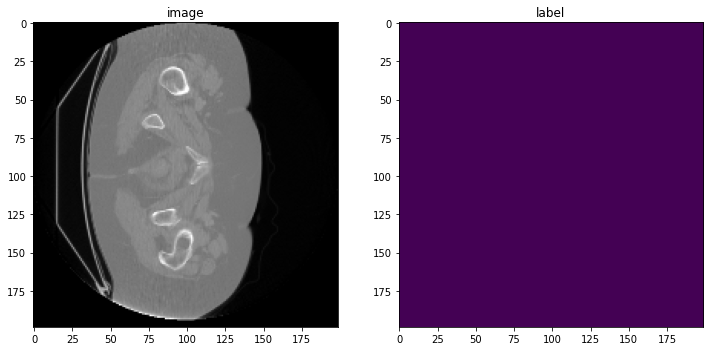

In [4]:

check_ds = Dataset(data=valid_list, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)


image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")


import matplotlib.pyplot as plt
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 55], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 55])
plt.show()
check_ds = Dataset(data=valid_list, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)


In [5]:
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")


image shape: torch.Size([199, 199, 486]), label shape: torch.Size([199, 199, 486])


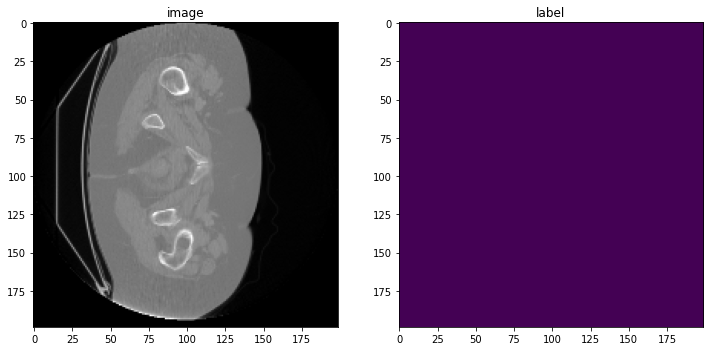

In [6]:
import matplotlib.pyplot as plt
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 55], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 55])
plt.show()

In [7]:
path_train = "./Train_samp"
if not os.path.exists(path_train):
        os.mkdir(path_train)

path_val = "./val_samp"
if not os.path.exists(path_val):
        os.mkdir(path_val)

root_dir = "./Res"
if not os.path.exists(root_dir):
        os.mkdir(root_dir)

loss_dir = "./loss"
if not os.path.exists(loss_dir):
        os.mkdir(loss_dir) 

In [8]:
####################
#### model
import monai

from monai.networks.nets import SwinUNETR
from monai.networks.nets import UNet
## Create Model, Loss, Optimizer
max_epochs = 30000000
val_interval = 1
VAL_AMP = True


train_dict = {}
train_dict["model_related"] = {}
train_dict["model_related"]["spatial_dims"] = 3
train_dict["model_related"]["in_channels"] = 1
train_dict["model_related"]["out_channels"] = 1
train_dict["model_related"]["channels"] = (8, 16, 32, 64, 128, 224)
train_dict["model_related"]["strides"] = (2, 2, 2, 2, 2)
train_dict["model_related"]["num_res_units"] = 9

import monai


model = SwinUNETR(
    img_size=(roi_x, roi_y, roi_z),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=True,
).to(device)



In [9]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")


optimizer = torch.optim.AdamW(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = LinearWarmupCosineAnnealingLR(
            optimizer, warmup_epochs=50, max_epochs=300
        )


In [10]:
# define inference method
def inference(input, roi):

    def _compute(input, roi):
        return sliding_window_inference(
            inputs=input,
            roi_size=roi,
            sw_batch_size=1,
            predictor=model,
            overlap=0.25,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input, roi)
    else:
        return _compute(input, roi)



In [11]:
# +
import time
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


best_metric = 0
best_metric_epoch = 0
epoch_loss_values = []
metric_values0 = []



In [12]:

post_label = AsDiscrete(to_onehot=1)
post_pred = AsDiscrete(argmax=True, to_onehot=1)



In [13]:

import nibabel as nib

x_file = nib.load('/src/workspace/BTCV/Fed_Training copy_2/Site_1_Test/For_FedTraining/data/39.nii')   
y_file = nib.load('/src/workspace/BTCV/Fed_Training copy_2/Site_1_Test/For_FedTraining/labels/39.nii')  


In [ ]:

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    
    model.train()
    
    
    
    epoch_loss = 0
    step = 0
    
    idx = 0
    ### First time
    
    
    
    for batch_data in train_loader:
        print(f" ===> Train: Epoch[{epoch+1}/{max_epochs}]->[{idx+1}]/[{len(train_loader)}]")
        
        step_start = time.time()
        step += 1
        #print(batch_data["image"])
        #print(batch_data["label"])
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        
        print(f'inputs.shape={inputs.shape}')
        print(f'labels.shape={labels.shape}')
        
        #for param in model.parameters():
        #    param.grad = None
        
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss_1 = loss_function(outputs, labels)
            
            print(f'outputs.shape={outputs.shape}')

            
            #loss_2 = loss_SSIM(labels.squeeze(0), outputs.squeeze(0), labels.max().unsqueeze(0))
            
            #print(f'\n\n\n \t = {loss_2}' )
                        
            loss = (loss_1) #+ loss_2
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_list) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
        
        
        if idx%5==0:
                import nibabel as nib
                
                        ##############################################################
                #print(np.shape(outputs))
                predW = outputs.cpu().detach().numpy()[0,0,:,:,:]
                #print(f'np.shape(predW)={np.shape(predW)}')
                pred_img = nib.Nifti1Image(predW, y_file.affine, y_file.header)
                path_img = path_train + '/'+str(idx) +'_Pred.nii'
                #print(f'path_img={path_img}')
                nib.save(pred_img, path_img) 

                x = inputs.cpu().detach().numpy()[0,0,:,:,:]
                x_img = nib.Nifti1Image(x, x_file.affine, x_file.header)
                path_img_x = path_train + '/'+str(idx) +'_X.nii'
                #print(f'path_img={path_img_x}')
                nib.save(x_img, path_img_x) 

                y = labels.cpu().detach().numpy()[0,0,:,:,:]
                #print(f'np.shape(y)={np.shape(y)}')
                y_img = nib.Nifti1Image(y, y_file.affine, y_file.header)
                path_img_y = path_train + '/'+str(idx) +'_Y.nii' 
                #print(f'path_img={path_img_y}')
                nib.save(y_img, path_img_y) 
                ############################################################


        idx +=1
        
        
        
    lr_scheduler.step()
    epoch_loss = np.mean(epoch_loss)
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    np.save("./loss/epoch_loss_"+"train"+"_{:03d}.npy".format(epoch+1), epoch_loss_values)
    
    
    
    
    id_val = 0
    epoch_val_loss0 = 0
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                #print(np.shape(outputs))
                #print(np.shape(val_labels))
                print(f" ===> Val: Epoch[{epoch+1}/{max_epochs}]->[{id_val+1}]/[{len(val_loader)}]")
                
                
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                
                print(f'val_inputs.shape={val_inputs.shape}')
                print(f'val_labels.shape={val_labels.shape}')
                
                roi = (128,128,128)
                
                val_outputs = inference(val_inputs, roi)
                
                """
                print(f'val_outputs.shape={val_outputs.shape}')
                
                val_labels_list = decollate_batch(val_labels)
                
                print(f'val_labels_list.shape={val_labels_list[0].shape},{len(val_labels_list)}')
                
                val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
                
                print(f'val_labels_convert.shape={val_labels_convert[0].shape},{len(val_labels_convert)}')
                
                val_outputs_list = decollate_batch(val_outputs)
                
                print(f'val_outputs_list.shape={val_outputs_list[0].shape},{len(val_outputs_list)}')
                
                val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
                
                print(f'val_output_convert.shape={val_output_convert[0].shape},{len(val_output_convert)}')
                
                print(f'\n\n\n before saving')
                """
                
                
                if id_val == 0:
                     ##############################################################
                    #print(np.shape(outputs))
                    
                    
                    
                    predW = val_outputs.cpu().detach().numpy()[0,0,:,:,:]
                    #print(f'np.shape(predW)={np.shape(predW)}')
                    pred_img = nib.Nifti1Image(predW, y_file.affine, y_file.header)
                    path_img = path_val + '/'+str(id_val) +'_Pred.nii'
                    #print(f'path_img={path_img}')
                    nib.save(pred_img, path_img) 
                    
                   

                    x = val_inputs.cpu().detach().numpy()[0,0,:,:,:]
                    x_img = nib.Nifti1Image(x, x_file.affine, x_file.header)
                    path_img_x = path_val + '/'+str(id_val) +'_X.nii'
                    #print(f'path_img={path_img_x}')
                    nib.save(x_img, path_img_x) 

                    y = val_labels.cpu().detach().numpy()[0,0,:,:,:]
                    #print(f'np.shape(y)={np.shape(y)}')
                    y_img = nib.Nifti1Image(y, y_file.affine, y_file.header)
                    path_img_y = path_val + '/'+str(id_val) +'_Y.nii' 
                    #print(f'path_img={path_img_y}')
                    nib.save(y_img, path_img_y) 
                    
                    """
                    y = val_labels_convert.cpu().detach().numpy()[0,0,:,:,:]
                    #print(f'np.shape(y)={np.shape(y)}')
                    y_img = nib.Nifti1Image(y, y_file.affine, y_file.header)
                    path_img_y = path_val + '/'+str(id_val) +'_Y_convert.nii' 
                    #print(f'path_img={path_img_y}')
                    nib.save(y_img, path_img_y)
                    
                    
                    predW = val_output_convert.cpu().detach().numpy()[0,0,:,:,:]
                    #print(f'np.shape(predW)={np.shape(predW)}')
                    pred_img = nib.Nifti1Image(predW, y_file.affine, y_file.header)
                    path_img = path_val + '/'+str(id_val) +'_Pred_convert.nii'
                    #print(f'path_img={path_img}')
                    nib.save(pred_img, path_img)
                    
                    """
                    
                    
                    
                    
                    
                    ############################################################
                    
                id_val += 1
                
                print(f'\n\n\n before dice metric')
                dice_metric(y_pred=val_outputs, y=val_labels)
  
                
               
                
                


            mean_dice_val = dice_metric.aggregate().item()
            
            print(f'\n\n\nmean_dice_val={mean_dice_val}\n\n\n\n')
            
            dice_metric.reset()
            
            acc = mean_dice_val
                
          
            
            metric_values0.append(acc)
            #metric_values2.append(metric2)
            #metric_values1.append(metric1)
            
            np.save("./loss/epoch_loss_"+"val"+"_{:03d}.npy".format(epoch+1), metric_values0)
            #np.save("./loss/epoch_loss_"+"val1"+"_{:03d}.npy".format(epoch+1), metric_values1)
            #np.save("./loss/epoch_loss_"+"val2"+"_{:03d}.npy".format(epoch+1), metric_values2)
            metric = acc
            

            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                #best_metrics_epochs_and_time[0].append(best_metric)
                #best_metrics_epochs_and_time[1].append(best_metric_epoch)
                #best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current loss: {metric:.4f}"
                #f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                #f"\nbest mean dice: {best_metric:.4f}"
                #f" at epoch: {best_metric_epoch}"
            )
            
    

----------
epoch 1/30000000
 ===> Train: Epoch[1/30000000]->[1]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])


/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:135: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


outputs.shape=torch.Size([1, 1, 64, 64, 64])
1/32, train_loss: 0.8620, step time: 2.3058
 ===> Train: Epoch[1/30000000]->[2]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])


/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:135: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


2/32, train_loss: 1.0000, step time: 0.3331
 ===> Train: Epoch[1/30000000]->[3]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
3/32, train_loss: 1.0000, step time: 0.3053
 ===> Train: Epoch[1/30000000]->[4]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
4/32, train_loss: 1.0000, step time: 0.3895
 ===> Train: Epoch[1/30000000]->[5]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
5/32, train_loss: 0.4293, step time: 0.3085
 ===> Train: Epoch[1/30000000]->[6]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
6/32, train_loss: 0.9793, step time: 0.3100
 ===> Train: Epoch[1/30000000]->[7]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])

/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:135: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


7/32, train_loss: 0.7877, step time: 0.3763
 ===> Train: Epoch[1/30000000]->[8]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
8/32, train_loss: 1.0000, step time: 0.3757
 ===> Train: Epoch[1/30000000]->[9]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
9/32, train_loss: 0.9944, step time: 0.3031
 ===> Train: Epoch[1/30000000]->[10]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
10/32, train_loss: 0.9071, step time: 0.3190
 ===> Train: Epoch[1/30000000]->[11]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
11/32, train_loss: 0.9353, step time: 0.3054
 ===> Train: Epoch[1/30000000]->[12]/[32]
inputs.shape=torch.Size([1, 1, 64, 64,

/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:135: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


12/32, train_loss: 1.0000, step time: 0.3446
 ===> Train: Epoch[1/30000000]->[13]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
13/32, train_loss: 0.9124, step time: 0.3032
 ===> Train: Epoch[1/30000000]->[14]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
14/32, train_loss: 1.0000, step time: 0.3751
 ===> Train: Epoch[1/30000000]->[15]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
15/32, train_loss: 0.9485, step time: 0.3872
 ===> Train: Epoch[1/30000000]->[16]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
16/32, train_loss: 1.0000, step time: 0.3115
 ===> Train: Epoch[1/30000000]->[17]/[32]
inputs.shape=torch.Size([1, 1, 64

/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:135: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/usr/local/lib/python3.8/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


17/32, train_loss: 0.9791, step time: 0.3809
 ===> Train: Epoch[1/30000000]->[18]/[32]
inputs.shape=torch.Size([1, 1, 64, 64, 64])
labels.shape=torch.Size([1, 1, 64, 64, 64])
outputs.shape=torch.Size([1, 1, 64, 64, 64])
18/32, train_loss: 1.0000, step time: 0.3809
